In [167]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Part One: Exploratory Data Analysis

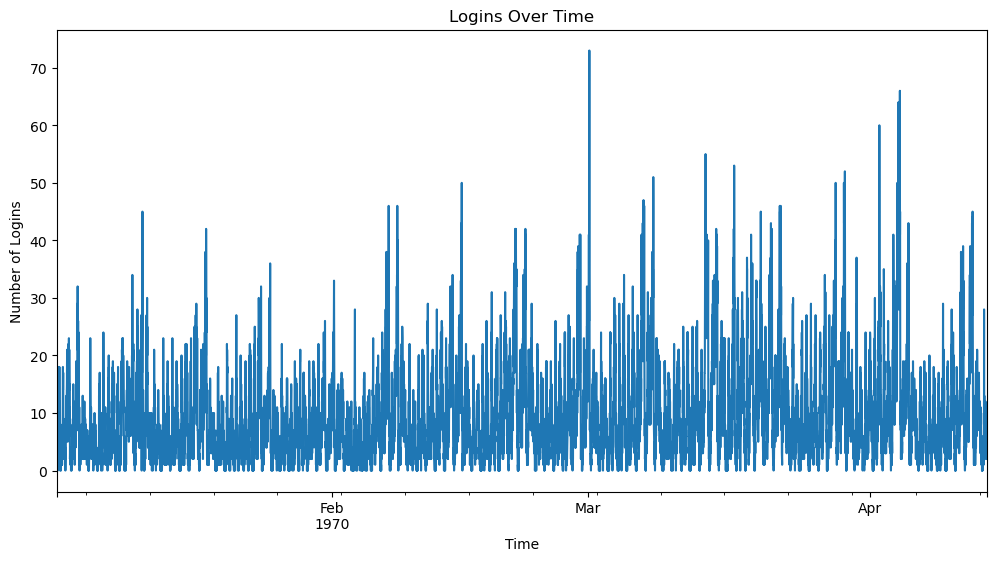

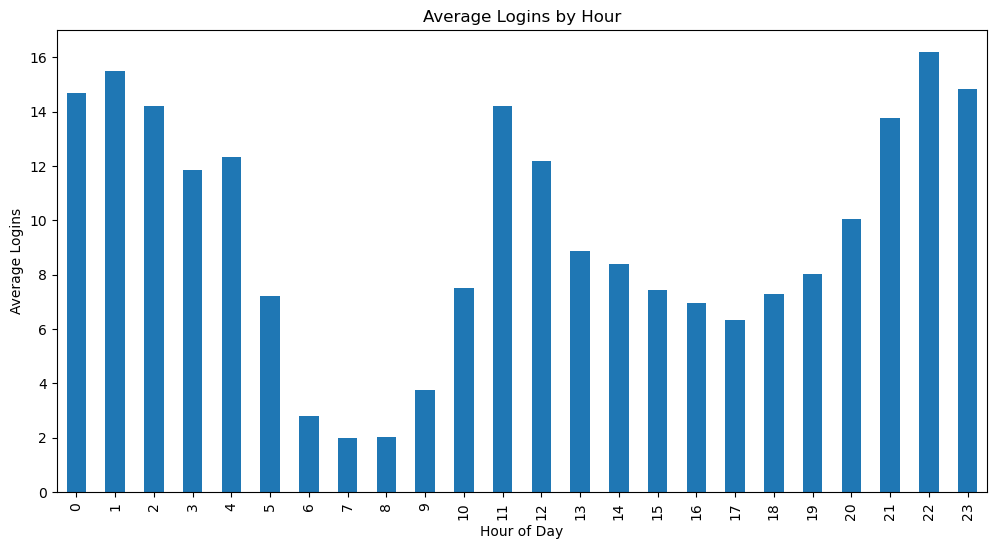

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

logins = pd.read_json("logins.json")

logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)

logins_15min = logins.resample('15min').size().to_frame(name='logins')

plt.figure(figsize=(12,6))
logins_15min['logins'].plot()
plt.title("Logins Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Logins")
plt.show()

logins_15min['hour'] = logins_15min.index.hour
logins_15min.groupby('hour')['logins'].mean().plot(kind='bar', figsize=(12,6))
plt.title("Average Logins by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Logins")
plt.show()


# Part Two: Experiment Metrics and Design

## Measures of Success

**Metric:** The percent of drivers who operate in both cities.

**Method:**  
1. Divide the drivers into two groups, one group for those who get toll reimbursements and those who don't get reimbursed.  
2. Compare the number of drivers in both cities across the two groups.  
3. Use Logistic Regression to determine the probability of the driver being in both cities based on their group.

**Recommendation:** If the model shows a higher rate of drivers working in both cities for the reimbursement group, then toll reimbursement should be implemented.



# Part Three: Predictive Modeling

In [125]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [127]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None
       trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
coun

In [131]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [133]:
last_date = df['last_trip_date'].max()

In [135]:
start_30days = last_date - pd.Timedelta(days=30)

In [137]:
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= start_30days else 0)

In [139]:
retention_rate = df['retained'].mean()
print(f"Retention rate based on last 30 days of data: {retention_rate:.2%}")

Retention rate based on last 30 days of data: 37.61%


In [141]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In [147]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['phone'] = df['phone'].fillna(df['phone'].mode()[0])

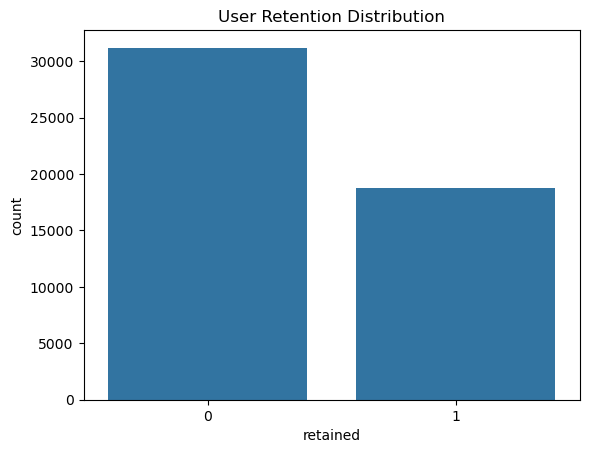

In [152]:
sns.countplot(x='retained', data=df)
plt.title('User Retention Distribution')
plt.show()

Retained = 1 and not retained = 0

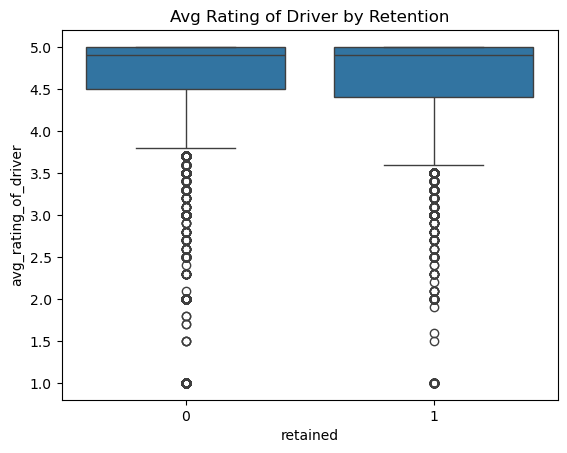

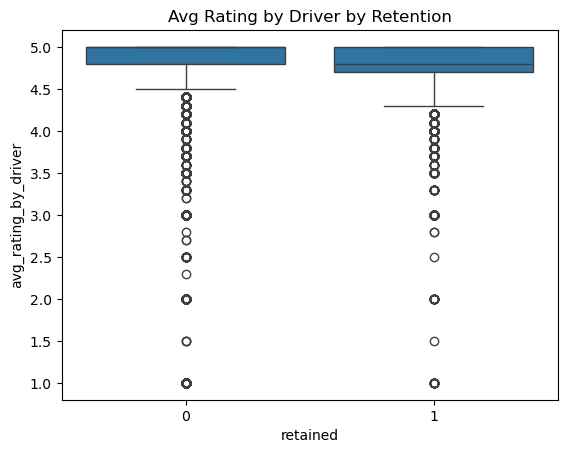

In [158]:
sns.boxplot(x='retained', y='avg_rating_of_driver', data=df)
plt.title('Avg Rating of Driver by Retention')
plt.show()

sns.boxplot(x='retained', y='avg_rating_by_driver', data=df)
plt.title('Avg Rating by Driver by Retention')
plt.show()

It seems like the drivers have more variable ratings, while riders are given more positive reviews. Both sides mostly have high ratings. 

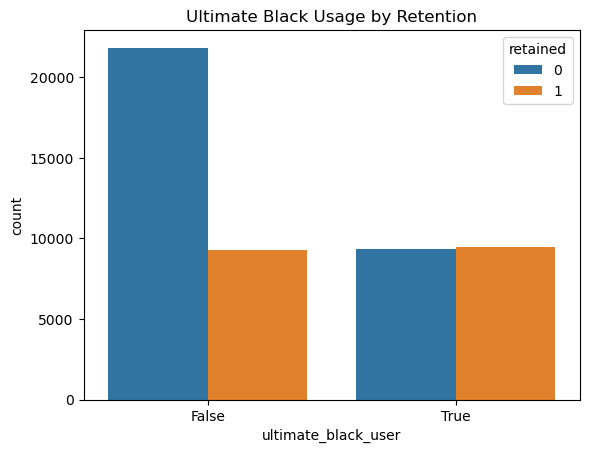

In [161]:
sns.countplot(x='ultimate_black_user', hue='retained', data=df)
plt.title('Ultimate Black Usage by Retention')
plt.show()

In [169]:
numeric_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                    'trips_in_first_30_days', 'avg_surge', 'surge_pct', 'weekday_pct']
categorical_features = ['city', 'phone', 'ultimate_black_user']

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [177]:
X = df.drop('retained', axis=1)
y = df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.71768
F1 Score: 0.572190568553764
ROC-AUC: 0.6748458810692852
Confusion Matrix:
 [[6611 1189]
 [2340 2360]]


In [181]:
model2 = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

C:\Users\Miranda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.78824
F1 Score: 0.7066385902693118
ROC-AUC: 0.7663925259138024
Confusion Matrix:
 [[6665 1135]
 [1512 3188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      7800
           1       0.74      0.68      0.71      4700

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



The XGBoost model is pretty good at predicting retention. It is slightly imbalanced since retention rate is lower than members who are retained. 

C:\Users\Miranda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:39:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


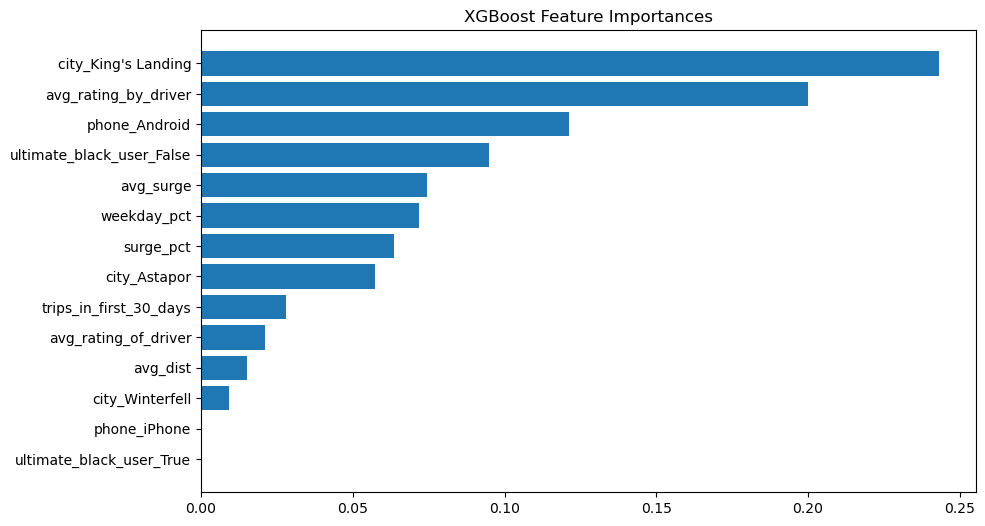

                      feature  importance
8         city_King's Landing    0.243162
1        avg_rating_by_driver    0.200013
10              phone_Android    0.121357
12  ultimate_black_user_False    0.094758
4                   avg_surge    0.074382
6                 weekday_pct    0.071811
5                   surge_pct    0.063605
7                city_Astapor    0.057457
3      trips_in_first_30_days    0.027909
2        avg_rating_of_driver    0.021065


In [206]:
model2 = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

model2.fit(X_train, y_train)

xgb_model = model2.named_steps['classifier']

feature_names = numeric_features + list(
    model2.named_steps['preprocessor']
          .named_transformers_['cat']
          .get_feature_names_out(categorical_features)
)

importances = xgb_model.feature_importances_

import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importance['feature'], feat_importance['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()

print(feat_importance.head(10))

# Summary

City of Signup: Users in King's Landing are the most likely to be retained, indicating that city factors influence retention. See if traffic reports can be used in future modeling. 

**Average Rating by Driver**: Higher rider ratings are associated with better retention, suggesting that positive trip experiences encourage continued use.

**Phone Type**: Users on Android devices are slightly more likely to be retained than users with other phone types. This is incredibly interesting and should be explored further in the future. 

**Ultimate Black Usage**: Users who did not take Ultimate Black trips in their first 30 days are slightly less likely to be retained, highlighting users who plan to use the service more often opt in for premium charges and services. 

**Trip Behavior Metrics**: Features like average surge, percentage of weekday trips, and surge percentage have moderate influence, showing that early usage patterns help predict retention.

**Other Insights**:

Focus marketing and engagement efforts on users in cities with lower predicted retention. 

Encourage users to have positive early experiences, especially ensuring high-quality trips and ratings. Maybe include a free trial to showcase product. 
